In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from parameters_pytorch import PyTorchNNParameters
from collections import OrderedDict
from scipy.linalg import orth, null_space
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Create a Simple Synthetic Dataset

In [2]:
class Data(Dataset):
    def __init__(self, X_train, y_train):
        self.X = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len
    
def getParameters():
    state_dict = OrderedDict()
    for k, v in self._core.state_dict().items():
        state_dict[k] = v.data.cpu().numpy()
    return PyTorchNNParameters(state_dict)

In [3]:
n_features = 8
n_samples = 600
batch_size = 4
n_classes = 3
hidden_dim = 16
hidden_dim2 = 16

X, Y = make_classification(n_samples=n_samples, n_features=n_features, n_redundant=0,n_informative=3,  
                           n_clusters_per_class=2, n_classes=n_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

X1_train, y1_train = X_train[:n_samples//2,:], Y_train[:n_samples//2]
X2_train, y2_train = X_train[n_samples//2:,:], Y_train[n_samples//2:]
train1,train2 = Data(X1_train, y1_train), Data(X2_train, y2_train)

trainloader1 = DataLoader(train1, batch_size=batch_size, shuffle=True)
trainloader2 = DataLoader(train2, batch_size=batch_size, shuffle=True)

# Train a Small MLP

In [4]:
class SmallNetwork(nn.Module):
    def __init__(self):
        super(SmallNetwork, self).__init__()
        self.linear1 = nn.Linear(n_features, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, n_classes)
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    def setParameters(self, param : PyTorchNNParameters):
        state_dict = OrderedDict()
        for k,v in param.get().items():
            #if self._mode == 'gpu':
            #    if v.shape == ():
            #        state_dict[k] = torch.tensor(v, device=self._device)
            #    else:
            #        state_dict[k] = torch.cuda.FloatTensor(v, device=self._device)
            #else:
            if v.shape == ():
                state_dict[k] = torch.tensor(v)
            else:
                state_dict[k] = torch.FloatTensor(v)
        self.load_state_dict(state_dict)

    def getParameters(self) -> PyTorchNNParameters:
        state_dict = OrderedDict()
        for k, v in self.state_dict().items():
            state_dict[k] = v.data.cpu().numpy()
        return PyTorchNNParameters(state_dict)
        
    def getPreviousParameters(self) -> PyTorchNNParameters:
        return self.old_params

    def _flattenParameters(self, param):
        flatParam = []
        for k,v in param.get().items():
            flatParam += np.ravel(v).tolist()
        return np.asarray(flatParam)
    
class SmallNetwork2(nn.Module):
    def __init__(self):
        super(SmallNetwork2, self).__init__()
        self.linear1 = nn.Linear(n_features, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, n_classes)
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    def setParameters(self, param : PyTorchNNParameters):
        state_dict = OrderedDict()
        for k,v in param.get().items():
            #if self._mode == 'gpu':
            #    if v.shape == ():
            #        state_dict[k] = torch.tensor(v, device=self._device)
            #    else:
            #        state_dict[k] = torch.cuda.FloatTensor(v, device=self._device)
            #else:
            if v.shape == ():
                state_dict[k] = torch.tensor(v)
            else:
                state_dict[k] = torch.FloatTensor(v)
        self.load_state_dict(state_dict)

    def getParameters(self) -> PyTorchNNParameters:
        state_dict = OrderedDict()
        for k, v in self.state_dict().items():
            state_dict[k] = v.data.cpu().numpy()
        return PyTorchNNParameters(state_dict)
        
    def getPreviousParameters(self) -> PyTorchNNParameters:
        return self.old_params

    def _flattenParameters(self, param):
        flatParam = []
        for k,v in param.get().items():
            flatParam += np.ravel(v).tolist()
        return np.asarray(flatParam)

In [5]:
def train(clf, trainloader,epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(clf.parameters(), lr=0.1)
    Ws = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = clf(inputs)
            loss = criterion(outputs, labels)
            # backward propagation
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
        Ws.append(clf.getParameters())
    return Ws

In [6]:
epochs = 50
clf1 = SmallNetwork2()
weights1 = train(clf1,trainloader1, epochs)
clf2 = SmallNetwork2()
weights2 = train(clf2,trainloader2, epochs)

np.linalg.norm(weights1[-1].toVector() - weights2[-1].toVector())

[1,    75] loss: 0.04203
[2,    75] loss: 0.04215
[3,    75] loss: 0.04166
[4,    75] loss: 0.04164
[5,    75] loss: 0.04055
[6,    75] loss: 0.04020
[7,    75] loss: 0.03920
[8,    75] loss: 0.03757
[9,    75] loss: 0.03624
[10,    75] loss: 0.03488
[11,    75] loss: 0.03391
[12,    75] loss: 0.03400
[13,    75] loss: 0.03349
[14,    75] loss: 0.03297
[15,    75] loss: 0.03222
[16,    75] loss: 0.03196
[17,    75] loss: 0.03142
[18,    75] loss: 0.03069
[19,    75] loss: 0.03057
[20,    75] loss: 0.03008
[21,    75] loss: 0.02970
[22,    75] loss: 0.02958
[23,    75] loss: 0.02939
[24,    75] loss: 0.02904
[25,    75] loss: 0.02915
[26,    75] loss: 0.02924
[27,    75] loss: 0.02876
[28,    75] loss: 0.02861
[29,    75] loss: 0.02846
[30,    75] loss: 0.02821
[31,    75] loss: 0.02796
[32,    75] loss: 0.02815
[33,    75] loss: 0.02766
[34,    75] loss: 0.02754
[35,    75] loss: 0.02684
[36,    75] loss: 0.02699
[37,    75] loss: 0.02677
[38,    75] loss: 0.02611
[39,    75] loss: 0.0

12.86151003583462

# Find the Span and Kernel of a Matrix

In [7]:
A = []
for w in weights1 + weights2:
    A.append(w.toVector())
A = np.array(A).T
S = orth(A)
K = null_space(A.T)
print(A.shape, S.shape, K.shape)

(467, 100) (467, 2) (467, 465)


### Create Test Data

In [8]:
testdata = Data(X_test, Y_test)
testloader = DataLoader(testdata, batch_size=len(testdata), shuffle=False)

In [9]:
def getTestLossAndAcc(clf, dataloader, criterion = nn.CrossEntropyLoss()):
    losses = []
    correct, total = 0, 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = clf(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss)
            __, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    avgloss = np.average(losses)
    return acc, avgloss

def getRandomUnitNoise(basis):
    alpha = np.random.rand(basis.shape[1])
    v = basis@alpha
    v = v / np.linalg.norm(v)
    return v


In [10]:
cleanAcc1, cleanLoss1 = getTestLossAndAcc(clf1, testloader)
cleanAcc2, cleanLoss2 = getTestLossAndAcc(clf2, testloader)

print("Network1: ", cleanAcc1, cleanLoss1, " Network2: ", cleanAcc2, cleanLoss2 )

Network1:  0.6060606060606061 0.85608244  Network2:  0.5454545454545454 0.9643288


In [11]:
n_tests = 100
sigma_interval = [0.001,10.0]

def getTestResultsNoise(A, clf, sigma_interval, n_tests = 100):
    results = {}
    params_orig = clf.getParameters().getCopy()
    vec_orig = params_orig.toVector()
    for i in range(n_tests):
        vec = getRandomUnitNoise(A)
        sigma = np.random.rand(1)*(sigma_interval[1] - sigma_interval[0]) + sigma_interval[0]
        vec *= sigma
        params = clf.getParameters()
        delta = vec_orig + vec
        params.fromVector(delta)
        clf.setParameters(params)

        acc, loss = getTestLossAndAcc(clf, testloader)

        results[sigma[0]] = [acc, loss]
    clf.setParameters(params_orig)
    return results

def getTestResultsNoiseAverage(clf1, clf2, sigma_interval, n_tests):
    results1, results2 = {}, {}
    params1_orig = clf1.getParameters().getCopy()
    vec1_orig = params1_orig.toVector()
    params2_orig = clf2.getParameters().getCopy()
    vec2_orig = params2_orig.toVector()
    avg_dir = vec1_orig - vec2_orig
    avg_dir /= np.linalg.norm(avg_dir)
    for i in range(n_tests):
        sigma = np.random.rand(1)*(sigma_interval[1] - sigma_interval[0]) + sigma_interval[0]
        vec = avg_dir*sigma
        
        params1 = clf1.getParameters()
        delta1 = vec1_orig + vec
        params1.fromVector(delta1)
        clf1.setParameters(params1)
        acc1, loss1 = getTestLossAndAcc(clf1, testloader)
        clf1.setParameters(params1_orig)
        results1[sigma[0]] = [acc1, loss1]
        
        params2 = clf2.getParameters()
        delta2 = vec2_orig - vec #go in the other direction for the other network
        params2.fromVector(delta2)
        clf2.setParameters(params2)
        acc2, loss2 = getTestLossAndAcc(clf2, testloader)
        clf2.setParameters(params2_orig)

        results2[sigma[0]] = [acc2, loss2]
    return results1, results2

In [12]:
subspace_res1 = getTestResultsNoise(S, clf1, sigma_interval, n_tests)
subspace_res2 = getTestResultsNoise(S, clf2, sigma_interval, n_tests)
nullspace_res1 =  getTestResultsNoise(K, clf1, sigma_interval, n_tests)
nullspace_res2 =  getTestResultsNoise(K, clf2, sigma_interval, n_tests)

avg_res1, avg_res2 = getTestResultsNoiseAverage(clf1, clf2, sigma_interval, n_tests)

In [13]:
sub_sigmas1 = subspace_res1.keys()
sub_losses1 = [subspace_res1[s][1] for s in sub_sigmas1]
sub_sigmas2 = subspace_res2.keys()
sub_losses2 = [subspace_res2[s][1] for s in sub_sigmas2]

null_sigmas1 = nullspace_res1.keys()
null_losses1 = [nullspace_res1[s][1] for s in null_sigmas1]
null_sigmas2 = nullspace_res2.keys()
null_losses2 = [nullspace_res2[s][1] for s in null_sigmas2]

avg_sigmas1 = avg_res1.keys()
avg_losses1 = [avg_res1[s][1] for s in avg_sigmas1]
avg_sigmas2 = avg_res2.keys()
avg_losses2 = [avg_res2[s][1] for s in avg_sigmas2]

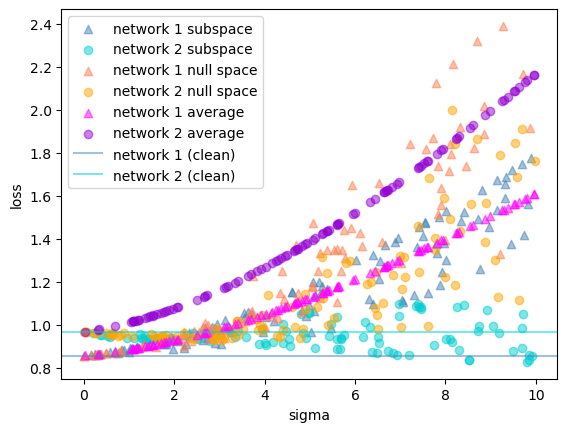

In [14]:
alpha = 0.5

plt.scatter(sub_sigmas1, sub_losses1, c='steelblue', marker = '^', label="network 1 subspace", alpha=alpha)
plt.scatter(sub_sigmas2, sub_losses2, c='darkturquoise', label="network 2 subspace", alpha=alpha)
plt.scatter(null_sigmas1, null_losses1, c='coral', marker = '^', label="network 1 null space", alpha=alpha)
plt.scatter(null_sigmas2, null_losses2, c='orange', label="network 2 null space", alpha=alpha)
plt.scatter(avg_sigmas1, avg_losses1, c='fuchsia', marker = '^', label="network 1 average", alpha=alpha)
plt.scatter(avg_sigmas2, avg_losses2, c='darkviolet', label="network 2 average", alpha=alpha)
plt.axhline(cleanLoss1, c='steelblue', label="network 1 (clean)", alpha=alpha)
plt.axhline(cleanLoss2, c='darkturquoise', label="network 2 (clean)", alpha=alpha)
plt.xlabel('sigma')
plt.ylabel('loss')
plt.legend()
plt.show()

# Layer-Wise Experiment

In [15]:
n_tests = 100
sigma_interval = [0.001,5.0]

def getLayerToIndex(clf):
    layerDescToIndex = {}
    layerToIndex = {}
    currPos = 0
    params = clf.getParameters()
    for k in params._shapes: #shapes contains the shapes of all weight matrices in the model and all the additional parameters, e.g., batch norm
        s = params._shapes[k]
        n = np.prod(s) #the number of elements n in the curent weight matrix
        index = list(range(currPos,currPos+n))
        layerDescToIndex[k] = index
        currPos += n
    l = 0
    for i in range(len(layerDescToIndex.keys())-1):
        desc1, desc2 = list(layerDescToIndex.keys())[i], list(layerDescToIndex.keys())[i+1]
        if "weight" in desc1 and "bias" in desc2:
            index = layerDescToIndex[desc1] + layerDescToIndex[desc2]
            layerToIndex[l] = index
            l += 1
    return layerToIndex

def embedVector(vec, layerToIndex, layer, d):
    v = np.zeros(d)
    for i in range(vec.shape[0]):
        idx = layerToIndex[l][i]
        v[idx] = vec[i]
    return v

def getTestResultsNoisePerLayer(A, layerToIndex, layer, clf, sigma_interval, n_tests = 100):
    results = {}
    params_orig = clf.getParameters().getCopy()
    vec_orig = params_orig.toVector()
    for i in range(n_tests):
        vec = getRandomUnitNoise(A)
        sigma = np.random.rand(1)*(sigma_interval[1] - sigma_interval[0]) + sigma_interval[0]
        vec *= sigma
        v = embedVector(vec, layerToIndex, layer, vec_orig.shape[0])
        params = clf.getParameters()
        delta = vec_orig + v
        params.fromVector(delta)
        clf.setParameters(params)

        acc, loss = getTestLossAndAcc(clf, testloader)

        results[sigma[0]] = [acc, loss]
    clf.setParameters(params_orig)
    return results

def getTestResultsNoiseAveragePerLayer(clf1, clf2, layerToIndex, layer, sigma_interval, n_tests):
    results1, results2 = {}, {}
    params1_orig = clf1.getParameters().getCopy()
    vec1_orig = params1_orig.toVector()
    params2_orig = clf2.getParameters().getCopy()
    vec2_orig = params2_orig.toVector()
    avg_dir = vec1_orig - vec2_orig
    avg_dir /= np.linalg.norm(avg_dir)
    for l in layerToIndex.keys():
        if l != layer:
            avg_dir[layerToIndex[l]] = 0.0
    for i in range(n_tests):
        sigma = np.random.rand(1)*(sigma_interval[1] - sigma_interval[0]) + sigma_interval[0]
        vec = avg_dir*sigma

        params1 = clf1.getParameters()
        delta1 = vec1_orig + vec
        params1.fromVector(delta1)
        clf1.setParameters(params1)
        acc1, loss1 = getTestLossAndAcc(clf1, testloader)
        clf1.setParameters(params1_orig)
        results1[sigma[0]] = [acc1, loss1]
        
        params2 = clf2.getParameters()
        delta2 = vec2_orig - vec #go in the other direction for the other network
        params2.fromVector(delta2)
        clf2.setParameters(params2)
        acc2, loss2 = getTestLossAndAcc(clf2, testloader)
        clf2.setParameters(params2_orig)

        results2[sigma[0]] = [acc2, loss2]
    return results1, results2

def plotResults(subspace_res1, subspace_res2, nullspace_res1, nullspace_res2, avg_res1, avg_res2):
    sub_sigmas1 = subspace_res1.keys()
    sub_losses1 = [subspace_res1[s][1] for s in sub_sigmas1]
    sub_sigmas2 = subspace_res2.keys()
    sub_losses2 = [subspace_res2[s][1] for s in sub_sigmas2]

    null_sigmas1 = nullspace_res1.keys()
    null_losses1 = [nullspace_res1[s][1] for s in null_sigmas1]
    null_sigmas2 = nullspace_res2.keys()
    null_losses2 = [nullspace_res2[s][1] for s in null_sigmas2]

    avg_sigmas1 = avg_res1.keys()
    avg_losses1 = [avg_res1[s][1] for s in avg_sigmas1]
    avg_sigmas2 = avg_res2.keys()
    avg_losses2 = [avg_res2[s][1] for s in avg_sigmas2]
    
    alpha = 0.5

    plt.scatter(sub_sigmas1, sub_losses1, c='steelblue', marker = '^', label="network 1 subspace", alpha=alpha)
    plt.scatter(sub_sigmas2, sub_losses2, c='darkturquoise', label="network 2 subspace", alpha=alpha)
    plt.scatter(null_sigmas1, null_losses1, c='coral', marker = '^', label="network 1 null space", alpha=alpha)
    plt.scatter(null_sigmas2, null_losses2, c='orange', label="network 2 null space", alpha=alpha)
    plt.scatter(avg_sigmas1, avg_losses1, c='fuchsia', marker = '^', label="network 1 average", alpha=alpha)
    plt.scatter(avg_sigmas2, avg_losses2, c='darkviolet', label="network 2 average", alpha=alpha)
    plt.axhline(cleanLoss1, c='steelblue', label="network 1 (clean)", alpha=alpha)
    plt.axhline(cleanLoss2, c='darkturquoise', label="network 2 (clean)", alpha=alpha)
    plt.xlabel('sigma')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [16]:
layerToIndex = getLayerToIndex(clf1)
A = []
for w in weights1 + weights2:
    A.append(w.toVector())
A = np.array(A).T

Layer  0 :



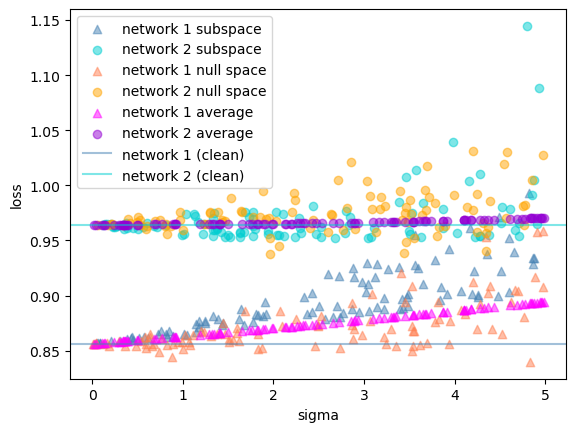

Layer  1 :



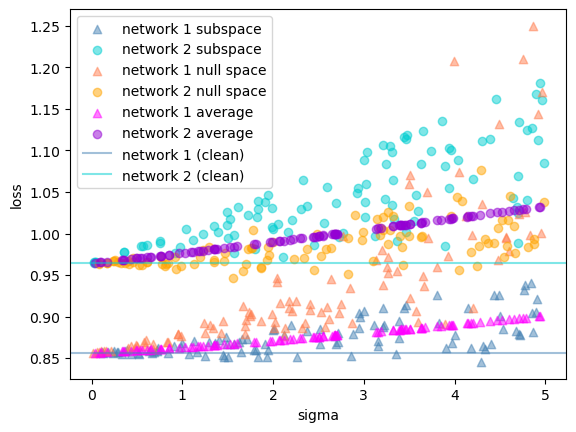

Layer  2 :



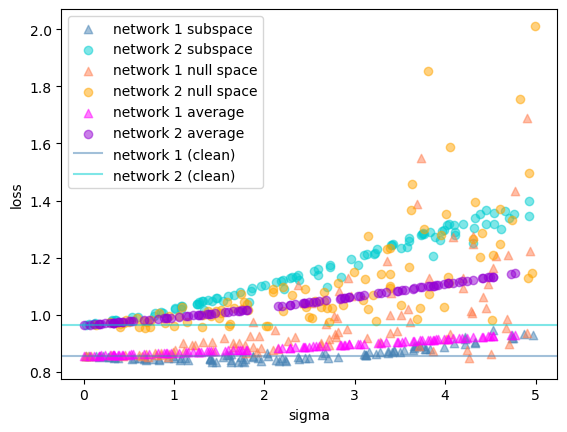

In [17]:
for l in range(len(layerToIndex.keys())):
    index = layerToIndex[l]
    Al = A[index,:]
    Sl = orth(Al)
    Kl = null_space(Al.T)
    
    subspace_res1 = getTestResultsNoisePerLayer(Sl, layerToIndex, l, clf1, sigma_interval, n_tests)
    subspace_res2 = getTestResultsNoisePerLayer(Sl, layerToIndex, l, clf2, sigma_interval, n_tests)
    nullspace_res1 =  getTestResultsNoisePerLayer(Kl, layerToIndex, l, clf1, sigma_interval, n_tests)
    nullspace_res2 =  getTestResultsNoisePerLayer(Kl, layerToIndex, l, clf2, sigma_interval, n_tests)

    avg_res1, avg_res2 = getTestResultsNoiseAveragePerLayer(clf1, clf2, layerToIndex, l, sigma_interval, n_tests)
    
    print("Layer ",l,":\n")
    plotResults(subspace_res1, subspace_res2, nullspace_res1, nullspace_res2, avg_res1, avg_res2)